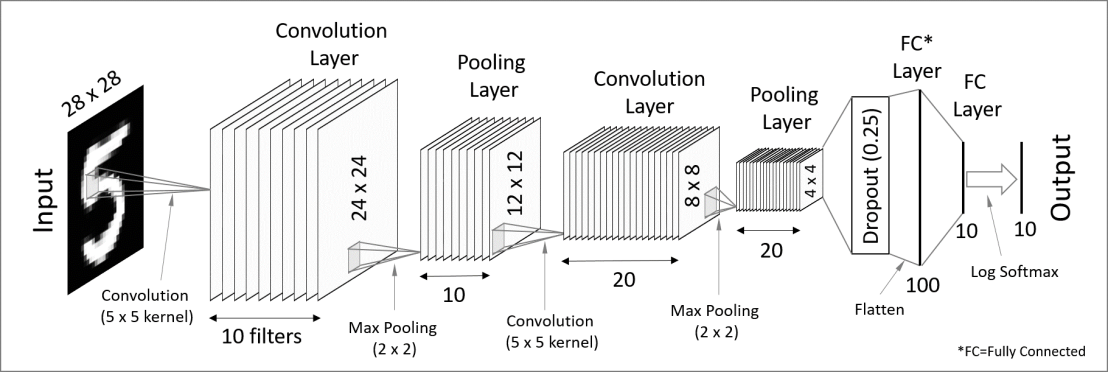

In [1]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# keras imports for the dataset and building our neural network
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier


# sklearn imports for the model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV


#Data-preparation

images = np.loadtxt("handwritten_digits_images.csv", delimiter=',')
labels = np.loadtxt("handwritten_digits_labels.csv", delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(images, labels,test_size=0.3, random_state=32)

#reshape data to fit model
X_train = X_train.reshape(49000,28,28,1)
X_test = X_test.reshape(21000,28,28,1)

#Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255
X_test /= 255


def make_model():
    
    model = Sequential()

    model.add(Conv2D(10,kernel_size=5, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(20, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   
    
    return model


def tuning(X_train,Y_train,X_test,Y_test):

    
    epochs = list(range(1,5))
    param_grid = dict(nb_epoch=epochs)

    k_model = KerasClassifier(build_fn=make_model, verbose=0)
   
    clf = GridSearchCV(estimator=k_model, param_grid=param_grid, 
                                   cv=5,
                                   scoring="accuracy", verbose=0 ,n_jobs=-1)
    clf.fit(X_train,Y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    
    model=make_model()
    
    return clf,model
    
clf = tuning(X_train,y_train,X_test,y_test)

Using TensorFlow backend.


Best parameters set found on development set:

{'nb_epoch': 4}


In [2]:
import time

model=clf[1]

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

start = time.time()
history = model.fit(X_train, y_train_enc, validation_data=(X_test, y_test_enc), epochs=4)
end = time.time()

exec_time = end - start

loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=2)

print()
print("Test Loss", loss)
print("Test Accuracy", accuracy)

predicted_classes = model.predict_classes(X_test)

# see which we predicted correctly and which not ----- Indices of elements that are non-zero.

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

error_rate = len(incorrect_indices)/(len(correct_indices)+len(incorrect_indices))

print()
print("Error rate : ", round(error_rate*100, 2), "%")

Train on 49000 samples, validate on 21000 samples
Epoch 1/4
49000/49000 [==============================] - 13s 267us/step - loss: 0.2775 - acc: 0.9161 - val_loss: 0.0934 - val_acc: 0.9727
Epoch 2/4
49000/49000 [==============================] - 13s 264us/step - loss: 0.0961 - acc: 0.9715 - val_loss: 0.0589 - val_acc: 0.9826
Epoch 3/4
49000/49000 [==============================] - 13s 268us/step - loss: 0.0712 - acc: 0.9778 - val_loss: 0.0469 - val_acc: 0.9860
Epoch 4/4
49000/49000 [==============================] - 13s 264us/step - loss: 0.0588 - acc: 0.9820 - val_loss: 0.0405 - val_acc: 0.9876

Test Loss 0.04046965615868214
Test Accuracy 0.9876190476190476

20740  classified correctly
260  classified incorrectly

Error rate :  1.24 %
